In [77]:
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import collections
from statistics import mean 
from scipy import signal
import math

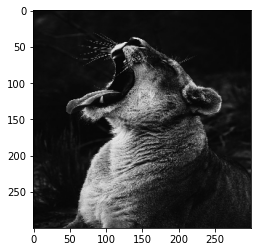

In [97]:
# image = cv.imread("cameraman.png")
lion=cv.imread("lion.jpg")

lion=cv.resize(lion, (300, 300))
# lion=lion[:1000,:1000,:]
lion.shape
plt.imshow(lion)
# image.shape[0]
#https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

# Second Derivative for img sharpening

![theory](markdown0.png)

In [3]:
spatial_window_v=np.array([[-1.0,-1.0,-1.0],[-1.0,8.0,-1.0],[-1.0,-1.0,-1.0]])
spatial_window_h=np.array([[-0.0,-1.0,-0.0],[-1.0,4.0,-1.0],[-0.0,-1.0,-0.0]])
f_w=3
#  processed_img_v[i+int(f_w/2),j+int(f_w/2)]=sum(abs(np.dot(window,filter_window_v).flatten()))
#  processed_img_h[i+int(f_w/2),j+int(f_w/2)]=sum(np.dot(window,filter_window_h).flatten())

In [4]:
def img_edge_detect(image,f_w,filter_window_v,filter_window_h):
    n=image.shape[0] #image size should be square (x,x,3)
    target_img_size=n-f_w+1 #dimension of target image 
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    processed_img_v= np.zeros(shape=(target_img_size, target_img_size))
    processed_img_h= np.zeros(shape=(target_img_size, target_img_size))

    for i in range(target_img_size):
        for j in range(target_img_size):
            window=image_gray[i:i+f_w, j:j+f_w].astype(float)
            
             # adding back img for better contrast
            processed_img_v[i,j]=int(image_gray[i,j]+round(sum(sum(window*filter_window_v))))
            processed_img_h[i,j]=int(image_gray[i,j]+round(sum(sum(window*filter_window_h))))
    
    ax,fig=plt.subplots(nrows=3, ncols=1, figsize=[15,15])
    plt.subplot(1,3,1)
    plt.title("Original image")
    plt.imshow(image,cmap="gray") #original image
    plt.subplot(1,3,2)
    plt.title("Common diagonal terms including laplacian")
    plt.imshow(processed_img_v,cmap="gray") #original image
    plt.subplot(1,3,3)
    plt.title("common laplacian ")
    plt.imshow(processed_img_h,cmap="gray") #transformed image
    return processed_img_v,processed_img_h


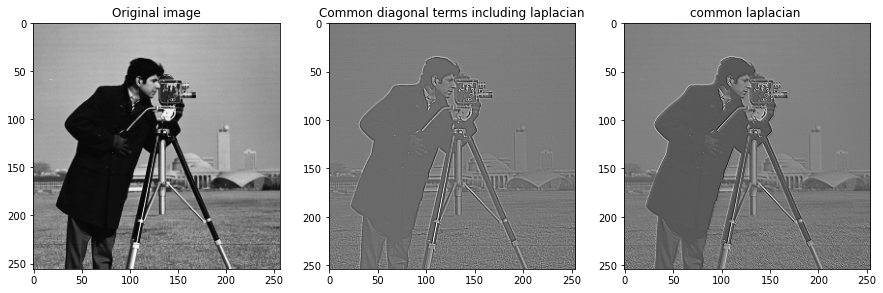

In [5]:
i,j=img_edge_detect(image,f_w,spatial_window_v,spatial_window_h)

In [6]:
i

array([[125., 159., 166., ..., 169., 163., 174.],
       [176., 166., 137., ..., 146., 130., 143.],
       [134., 164., 164., ..., 172., 163., 174.],
       ...,
       [ 84., 202., 220., ..., -41., 176., 130.],
       [202.,  93., -19., ..., 322., 155., 226.],
       [125., 112., 482., ...,  15., 165., 167.]])

# Unsharp masking & Highboost Filtering
1.Blur image <br>
2.Subtract the blur img from the orig img (this is the mask) <br>
3. add the mask to the orig img

In [7]:
def matlab_style_gauss2D(shape=(3,3),sigma=1.0):
    
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [8]:
filter_window=np.array(np.array(matlab_style_gauss2D()))
f_w=3


In [9]:
def img_unsharp_masking(image,f_w,filter_window):
    n=image.shape[0] #image size should be square (x,x,3)
    target_img_size=n-f_w+1 #dimension of target image 
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#     processed_img= np.zeros(shape=(target_img_size, target_img_size))
    processed_img=image_gray[:,:].astype(float).copy()
    for i in range(target_img_size):
        for j in range(target_img_size):
            window=image_gray[i:i+f_w, j:j+f_w].astype(float)
             # adding back img for better contrast
            processed_img[i,j]=int(2*image_gray[i,j]-abs(sum(sum(window*filter_window))))
            
    
    ax,fig=plt.subplots(nrows=3, ncols=1, figsize=[12,12])
    plt.subplot(1,2,1)
    plt.title("Original image")
    plt.imshow(image,cmap="gray") #original image
    plt.subplot(1,2,2)
    plt.title(" Unsharp masking & Highboost Filtering(image)")
    plt.imshow(processed_img,cmap="gray") #transformed img
    
    return processed_img


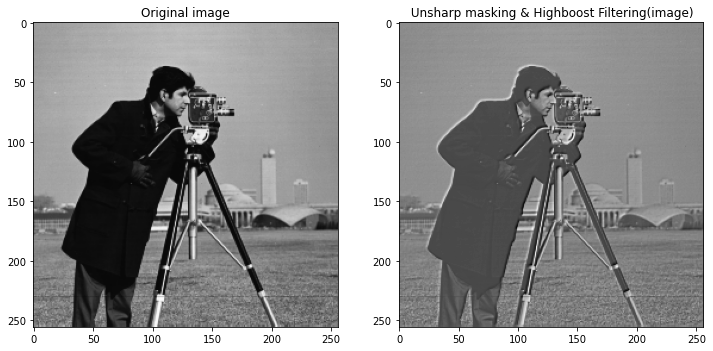

In [10]:
im=img_unsharp_masking(image,f_w,filter_window)

# Using first order derivative for non linear img sharpening (gradient)

![theory](first_derivative.png)

### M(x,y) =|g(x) | + |g(y)|
### M(x,y) = np.sqrt(g(x)**2 +g(y)**2)

In [11]:
f_w=3
spatial_window_sx=np.array([[-1.0,-1.0,-1.0],[0.0,0.0,0.0],[1.0,1.0,1.0]])
spatial_window_sy=np.array([[-1.0,0.0,1.0],[-1.0,0.0,1.0],[-1.0,0.0,1.0]])

In [12]:
def img_sharpening_gradient_method(image,f_w,filter_window_x,filter_window_y):
    n=image.shape[0] #image size should be square (x,x,3)
    target_img_size=n-f_w+1 #dimension of target image 
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed_img_v= np.zeros(shape=(target_img_size, target_img_size))
    processed_img_h= np.zeros(shape=(target_img_size, target_img_size))
#     processed_img_h=image_gray[:,:].astype(float).copy()
#     processed_img_v=image_gray[:,:].astype(float).copy()
    for i in range(target_img_size):
        for j in range(target_img_size):
            window=image_gray[i:i+f_w, j:j+f_w].astype(float)
            
            # calculating M(x,y)
            # using M(x,y) =|g(x) | + |g(y)|
            processed_img_v[i,j]=int(abs(round(sum(sum(window*filter_window_x))) ) + abs(round(sum(sum(window*filter_window_y)))))
            

            # using M(x,y) = np.sqrt(g(x)**2 +g(y)**2)
            
            processed_img_h[i,j]=int(round(np.sqrt((sum(sum(window*filter_window_x)).astype(float)**2) +(sum(sum(window*filter_window_y)).astype(float)**2)))) 
    
            #print(processed_img_h[i,j])
    
    ax,fig=plt.subplots(nrows=3, ncols=1, figsize=[12,12])
    plt.subplot(1,3,1)
    plt.title("Original image")
    plt.imshow(image,cmap="gray") #original image
    plt.subplot(1,3,2)
    plt.title(" using M(x,y) =|g(x) | + |g(y)|")
    plt.imshow(processed_img_v,cmap="gray") #transformed image
    plt.subplot(1,3,3)
    plt.title("using  M(x,y) = np.sqrt(g(x)**2 +g(y)**2) ")
    plt.imshow(processed_img_h,cmap="gray") #transformed image
    return processed_img_v,processed_img_h

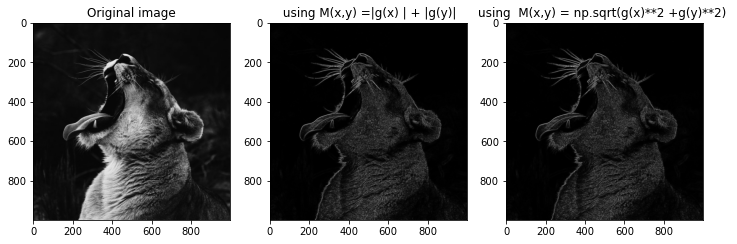

In [13]:
imv,imh=img_sharpening_gradient_method(lion,f_w,spatial_window_sx,spatial_window_sy)

# <b> THE CANNY EDGE DETECTOR </b>


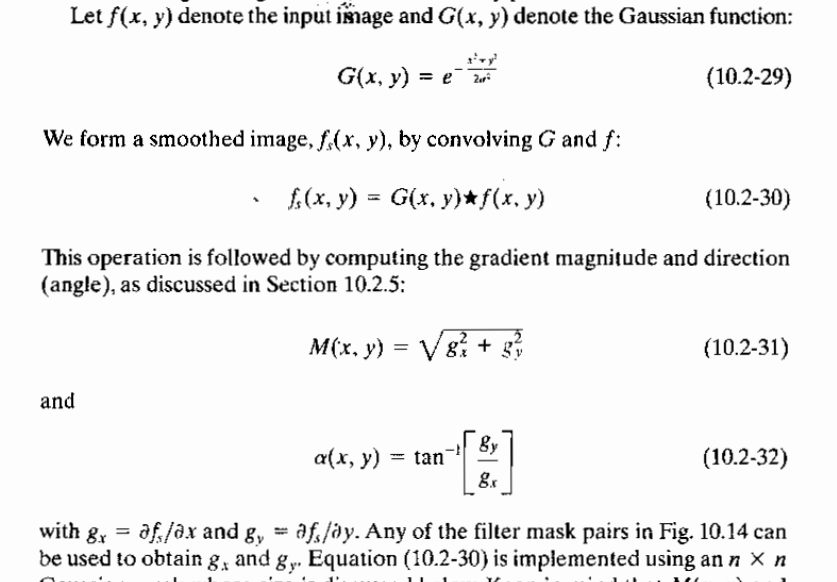
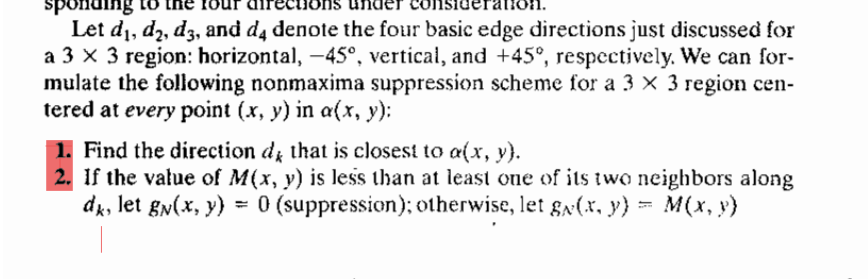

# 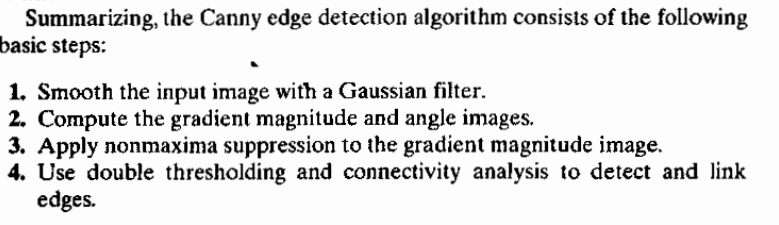

In [14]:
def G(x,y,sigma):
    """ Gaussian Filter"""
    return np.exp(-(x**2+y**2)/2*(sigma**2))



In [15]:
def closest(lst, K):
    """ To identify the closest direction in dk for any particular alpha
    Input :
        lst : list of items (direction list) from which closest direction have to be identified
        k   : alpha value 
    """
     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [16]:
def gradient_calculation(image,f_w,filter_window_x,filter_window_y):
    """ 
       calculation of gradient of input image 
       INPUT :
       filter_window_x - gx (gradient of x) calculating matrix
       filter_window_y - gy (gradient of y) calculating matrix
       f_w - floating window dimension 
       OUTPUT :
       Mxy - Magnitude of gradient 
       alpha - angle of derivative at that point
    """
    n=image.shape[0] #image size should be square (x,x,3)
    target_img_size=n-f_w+1 #dimension of target image 
    image_gray=image
    Mxy= np.zeros(shape=(n, n))
    alpha= np.zeros(shape=(n, n))
    for i in range(target_img_size):
        for j in range(target_img_size):
            window=image_gray[i:i+f_w, j:j+f_w].astype(float)
            # calculating M(x,y)
            Mxy[i][j]=round(np.sqrt((sum(sum(window*filter_window_x)).astype(float)**2) +(sum(sum(window*filter_window_y)).astype(float)**2))) 
            #calculating alpha(x,y)
            if(round(sum(sum(window*filter_window_y)))>0):
                alpha[i][j]=math.atan(round(sum(sum(window*filter_window_x))) / round(sum(sum(window*filter_window_y))) )
            else:
                alpha[i][j]=math.pi/2
    return Mxy,alpha

In [17]:
#  img_g=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# mxy,alpha=gradient_calculation(img_g,f_w,spatial_window_sx,spatial_window_sy)
def removing_zero(image):
    n=image.shape[0]
    m=image.shape[1]
    size_x=0
    size_y=0
    for i in range(n):
        if(image[i,0]==0):
            size_x=i
            break
    for i in range(m):
        if(image[0,i]==0):
            size_y=i
            break
    return(size_x,size_y)

In [153]:
#kernel
K=np.zeros((7,7))
for i in range (-3,4):
    for j in range(-3,4):
        K[i+3,j+3]=G(i,j,1)

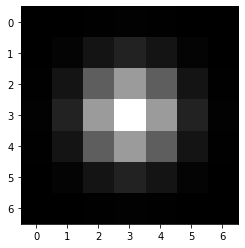

In [42]:
plt.imshow(K,cmap="gray")

In [243]:
def Canny_Edge(image,sigma,f_w,filter_window_x,filter_window_y,Tl,Th,Kernel):
    """
    INPUT:
    
         image -        input image in rgb format
         sigma-         for gaussian filter
         f_w -          floating window for gradient calculation
         filter_window_x - gx (gradient of x) calculating matrix
         filter_window_y - gy (gradient of y) calculating matrix
         Tl-            low threshold value for double thresholding
         Th-            high threshold value for duble thresholding
     
    OUTPUT:
    
        gnXY  : Non-maxima suppressed image
        gnlXY : Low threshold image by removing pixels having value lower than the threshold
        gnhXY : High threshold image by removing pixels having value lower than the threshold
        
    """
    img_g=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    Gxy=img_g.copy()
    #step 01

    Fs=signal.convolve(Kernel,img_g)  #smoothening image  (image size getting smaller)

    
   
    
    #step 02 gradient magnitude and angle images
    Mxy,alpha=gradient_calculation(Fs,f_w,filter_window_x,filter_window_y)
    
    
    #step 03 non-maxima supression to Mxy(gradient magnitude image)
    dk=[0.00,math.pi/4,-math.pi/4,math.pi/2]
    dxy=alpha.copy()
    for i in range(dxy.shape[0]):
        for j in range(dxy.shape[1]):
            dxy[i][j]=closest(dk,alpha[i][j])
    gnXY=np.zeros(shape=(alpha.shape[0], alpha.shape[0])) #non maxima supressed image
    
    for i in range(dxy.shape[0]-2):
        for j in range(dxy.shape[0]-2):
            #3*3 dim window is taken as per book
            window=Mxy[i:i+3, j:j+3].astype(float) 
            if(dxy[i+1][j+1]==dk[0]):  #direction matching 
                if((Mxy[i+1][j+1]<Mxy[i+1][j]) or (Mxy[i+1][j+1]<Mxy[i+1][j+2])):
                    gnXY[i+1][j+1]=0
                    
                else:
                    gnXY[i+1][j+1]=Mxy[i+1][j+1]
            elif(dxy[i+1][j+1]==dk[1]):
                if((Mxy[i+1][j+1]<Mxy[i][j+2]) or (Mxy[i+1][j+1]<Mxy[i+2][j])):
                    gnXY[i+1][j+1]=0
                else:
                    
                    gnXY[i+1][j+1]=Mxy[i+1][j+1]
            elif(dxy[i+1][j+1]==dk[2]):
                if((Mxy[i+1][j+1]<Mxy[i][j]) or (Mxy[i+1][j+1]<Mxy[i+2][j+2])):
                    gnXY[i+1][j+1]=0
                else:
                    gnXY[i+1][j+1]=Mxy[i+1][j+1]
                    
            else:
                if((Mxy[i+1][j+1]<Mxy[i][j+1]) or (Mxy[i+1][j+1]<Mxy[i+2][j+1])):
                    gnXY[i+1][j+1]=0
                else:
                    gnXY[i+1][j+1]=Mxy[i+1][j+1]
                    
    #gnXY - non maxima supressed image
    
    #step 04 double thresholding and connectivity analysis
    #Tl - low threshold , Th- High threshold
    gnhXY=np.zeros((gnXY.shape[0],gnXY.shape[1]))
    gnlXY=np.zeros((gnXY.shape[0],gnXY.shape[1]))
    for i in range(gnXY.shape[0]):
        for j in range(gnXY.shape[1]):
                if(gnXY[i,j]< Th):
                    gnhXY[i,j]=0
                else:
                    gnhXY[i,j]=255
                if(gnXY[i,j]< Tl):
                    gnlXY[i,j]=0
                else:
                    gnlXY[i,j]=255
                
    #final step 
    
    gnlXY=gnlXY-gnhXY #subtracting from low threshold image all the edges present in high threshold img
    modifiled_gnl=np.zeros(shape=(gnlXY.shape[0],gnlXY.shape[1] ))
    gnl_1=gnlXY.copy()
    gnh_1=gnhXY.copy()
    for i in range(gnhXY.shape[0]):
        for j in range(gnhXY.shape[1]):
            if(gnhXY[i,j]!=0):
                gnl_window=gnlXY[i-1:i+2,j-1:j+2]
                indices=np.nonzero(gnl_window)
                ind_size=len(indices[0])
                for k in range(0,ind_size):
                    if(gnlXY[i-1+indices[0][k],j-1+indices[1][k]]!=0.0):
                        gnl_1[i-1+indices[0][k],j-1+indices[1][k]]=0
                        gnh_1[i-1+indices[0][k],j-1+indices[1][k]]=255
                        modifiled_gnl[i-1+indices[0][k],j-1+indices[1][k]]= 255
    gnl_2=gnl_1.copy()
    gnh_2=gnh_1.copy()
    for i in range(gnhXY.shape[0]-1,-1):
        for j in range(gnhXY.shape[1]-1,-1):
            if(gnh_1[i,j]!=0):
                gnl_window=gnl_1[i-1:i+2,j-1:j+2]
                indices=np.nonzero(gnl_window)
                ind_size=len(indices[0])
                for k in range(0,ind_size):
                    if(gnl_1[i-1+indices[0][k],j-1+indices[1][k]]!=0.0):
                        gnl_2[i-1+indices[0][k],j-1+indices[1][k]]=0
                        gnh_2[i-1+indices[0][k],j-1+indices[1][k]]=255
                        modifiled_gnl[i-1+indices[0][k],j-1+indices[1][k]]= 255             
    gnl_3=gnl_2.copy()
    gnh_3=gnh_2.copy()
    for i in range(gnhXY.shape[0]):
            for j in range(gnhXY.shape[1]-1,-1):
                if(gnh_2[i,j]!=0):
                    gnl_window=gnl_2[i-1:i+2,j-1:j+2]
                    indices=np.nonzero(gnl_window)
                    ind_size=len(indices[0])
                    for k in range(0,ind_size):
                        if(gnl_2[i-1+indices[0][k],j-1+indices[1][k]]!=0.0):
                            gnl_3[i-1+indices[0][k],j-1+indices[1][k]]=0
                            gnh_3[i-1+indices[0][k],j-1+indices[1][k]]=255
                            modifiled_gnl[i-1+indices[0][k],j-1+indices[1][k]]= 255                    
    gnl_4=gnl_3.copy()
    gnh_4=gnh_3.copy()
    for i in range(gnhXY.shape[0]-1,-1):
            for j in range(gnhXY.shape[1]):
                if(gnh_3[i,j]!=0):
                    gnl_window=gnl_3[i-1:i+2,j-1:j+2]
                    indices=np.nonzero(gnl_window)
                    ind_size=len(indices[0])
                    for k in range(0,ind_size):
                        if(gnl_3[i-1+indices[0][k],j-1+indices[1][k]]!=0.0):
                            gnl_4[i-1+indices[0][k],j-1+indices[1][k]]=0
                            gnh_4[i-1+indices[0][k],j-1+indices[1][k]]=255
                            modifiled_gnl[i-1+indices[0][k],j-1+indices[1][k]]= 255                 
                        
    gnh_final=gnh_4+modifiled_gnl  
    return dxy,Fs,gnXY ,gnlXY,gnhXY, gnh_final
    
    

In [251]:
sigma=1
f_w=3
Th=250
Tl=100

dxy,Fs,gnXY ,gnlXY,gnhXY,gnh_final=Canny_Edge(image,sigma,f_w,spatial_window_sx,spatial_window_sy,Tl,Th,K)



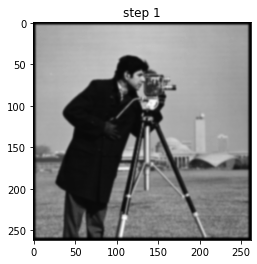

In [252]:
plt.title("step 1")
plt.imshow(Fs,cmap="gray")

<font color="red"> non-maximal one has issue !!!!
solve it</font>

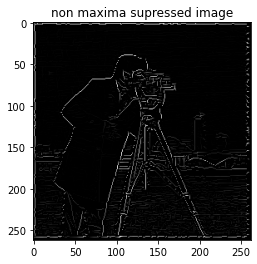

In [253]:
plt.title("non maxima supressed image")
plt.imshow(gnXY,cmap="gray")

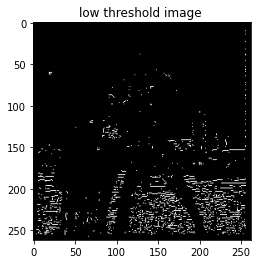

In [254]:
plt.title("low threshold image ")
plt.imshow(gnlXY,cmap="gray")

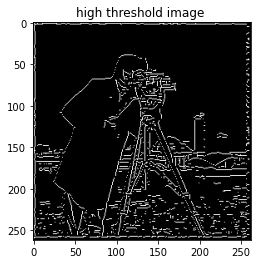

In [255]:
plt.title("high threshold image ")
plt.imshow(gnhXY,cmap="gray")

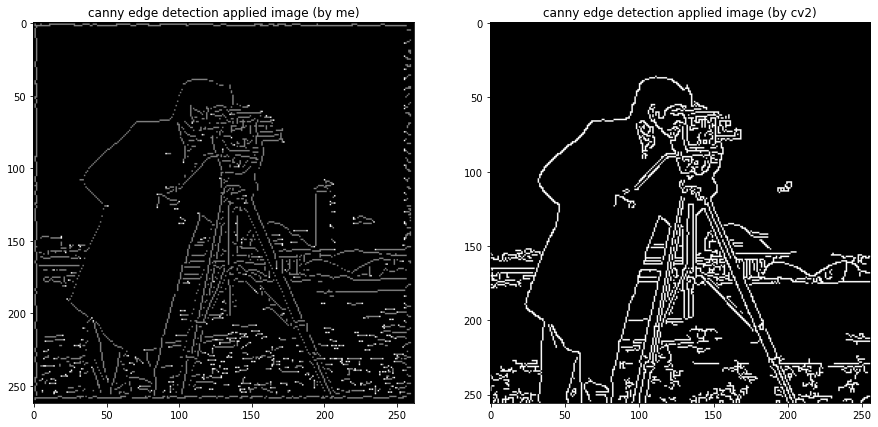

In [256]:
ax,fig=plt.subplots(nrows=2, ncols=1, figsize=[15,15])
plt.subplot(1,2,1)
plt.title("canny edge detection applied image (by me)")
plt.imshow(gnh_final,cmap="gray")
plt.subplot(1,2,2)
plt.title("canny edge detection applied image (by cv2)")
edges=cv.Canny(image,100,250)
plt.imshow(edges,cmap="gray")



In [257]:

#hough transformation line , circle, ellipse